* A toy implementation of DCGAN with TensorFlow
* Refer to this tutorial: http://bamos.github.io/2016/08/09/deep-completion/
* DCGAN paper: https://arxiv.org/abs/1511.06434

In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import Image
%matplotlib inline

In [2]:
tf.__version__

'1.2.1'

In [3]:
Z_SIZE = 100

BATCH_SIZE = 100
IMG_H = 28
IMG_W = 28
IMG_CHANNELS = 1  # 64x64, Colored images for MsCeleb: http://www.msceleb.org/download/sampleset

In [4]:
def random_z(shape):
    return np.random.uniform(-1., 1., size=shape)

# Utilities

In [5]:
def show_image(x):
    """Show gray image from 28x28 matrix"""
    if len(x.shape) == 2:
        plt.figure(figsize = (1,1))
        plt.axis('off')
        plt.imshow(1-x, cmap=cm.Greys)
    else:
        if x.shape[0] > 10:
            x = x[:10]
        plt.figure(figsize = (16,16))
        for i in range(x.shape[0]):
            plt.subplot(1, x.shape[0], i+1)
            plt.axis('off')
            plt.imshow(1-x[i], cmap=cm.Greys)
    plt.show()
    
def show_loss_chart(rounds, d_loss_values, g_loss_values):
    sns.set_style("darkgrid")
    plt.plot(rounds, d_loss_values, 'g', label="Discriminator")
    plt.plot(rounds, g_loss_values, 'r', label="Generator")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

# Load data

In [6]:
mnist = input_data.read_data_sets('mnist/', one_hot = True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


# Show some real MNIST training images

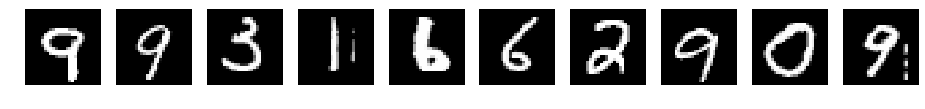

In [28]:
show_image(mnist.train.images[10:20].reshape((10,IMG_W, IMG_H)))

# Generator in DCGAN

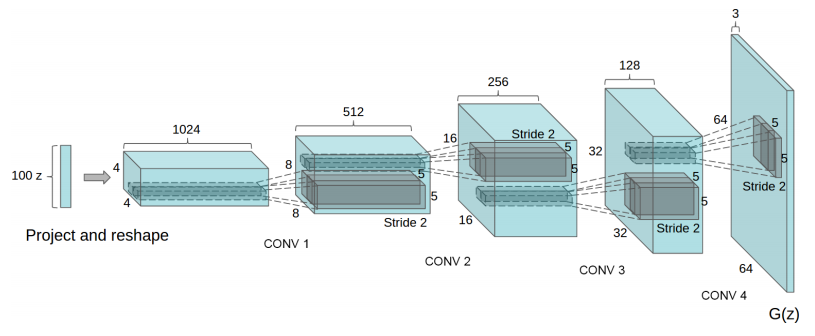

In [3]:
Image(filename='dcgan-generator-architecture.png') 

* Credit: Radford et al, ICLR 2016

* For MNIST data: 100 x 1 -> 7 x 7 x 512 -> 14 x 14 x 128 -> 28 x 28 x 64 -> 28 x 28 x 1

In [8]:
gf_dim = 16
d_h = 2
d_w = 2
k_h = 5 
k_w = 5

In [9]:
def init(shape):
    # Xavier init
    # Ref: https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
    stddev = 1. / np.sqrt((np.sum(shape) / 2.))
    return tf.random_normal(shape=shape, stddev=stddev)

In [15]:
Z = tf.placeholder(tf.float32, shape=(None, Z_SIZE))

# Transform the input Z
# g_h0_W = tf.Variable(tf.random_normal(shape=[Z_SIZE, gf_dim*4*7*7], stddev=0.2), name='g_h0_W')
g_h0_W = tf.Variable(init([Z_SIZE, gf_dim*4*7*7]), name='g_h0_W')
g_h0_b = tf.Variable(tf.zeros([gf_dim*4*7*7]), name='g_h0_b')
Z_ = tf.matmul(Z, g_h0_W) + g_h0_b

# BatchNorm layer
Z_reshape = tf.reshape(Z_, [BATCH_SIZE, 7, 7, gf_dim*4])
bns = tf.contrib.layers.batch_norm(Z_reshape, decay=0.9, updates_collections=None, epsilon=1e-5, center=True, scale=True, is_training=True)
g_h0 = tf.nn.relu(bns)  # [None, 7, 7, 64]

In [17]:
# Transpose Convolution layer
in_shape = g_h0.get_shape().as_list()
out_shape = [BATCH_SIZE, 14, 14, gf_dim*2]

g_h1_W = tf.Variable(init([k_h, k_w, out_shape[-1], in_shape[-1]]), name='g_h1_W')
g_h1_b = tf.Variable(tf.zeros([out_shape[-1]]), name='g_h1_b')
g_deconv1 = tf.nn.conv2d_transpose(g_h0, g_h1_W, output_shape=out_shape, strides=[1, d_h, d_w, 1]) + g_h1_b
bns = tf.contrib.layers.batch_norm(g_deconv1, decay=0.9, updates_collections=None, epsilon=1e-5, center=True, scale=True, is_training=True)
g_h1 = tf.nn.relu(bns)     # [None, 14, 14, 32]


# Transpose Convolution layer -> Image
in_shape = g_h1.get_shape().as_list()
out_shape = [BATCH_SIZE, 28, 28, IMG_CHANNELS]

g_out_W = tf.Variable(init([k_h, k_w, out_shape[-1], in_shape[-1]]), name='g_out_W')
g_out_b = tf.Variable(tf.zeros([out_shape[-1]]), name='g_out_b')
g_image = tf.nn.sigmoid(tf.nn.conv2d_transpose(g_h1, g_out_W, output_shape=out_shape, strides=[1, d_h, d_w, IMG_CHANNELS]) + g_out_b)    # [None, 14, 14, 1]

In [18]:
g_trainables = [g_h0_W, g_h0_b, g_h1_W, g_h1_b, g_out_W, g_out_b]

# Discriminator in DCGAN

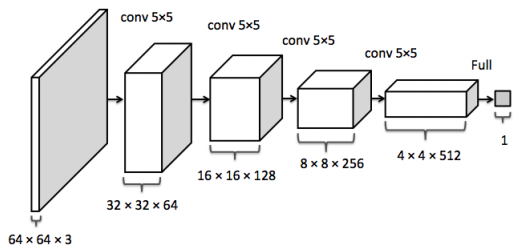

In [19]:
Image(filename='dcgan-discriminator-architecture.png') 

* Credit: Radford et al, ICLR 2016

* For MNIST data: 28 x 28 x 1 -> 14 x 14 x 64 -> 7 x 7 x 128 -> 1

In [20]:
X = tf.placeholder(tf.float32, shape=[None, IMG_H, IMG_W, IMG_CHANNELS])

In [21]:
FMAPS1 = 64
FMAPS2 = 128

d_W_conv1 = tf.Variable(init([5, 5, IMG_CHANNELS, FMAPS1]), name='d_W_conv1')
d_b_conv1 = tf.Variable(tf.constant(0.1, shape=[FMAPS1]), name='d_b_conv1')

d_W_conv2 = tf.Variable(init([5, 5, FMAPS1, FMAPS2]), name='d_W_conv2')
d_b_conv2 = tf.Variable(tf.constant(0.1, shape=[FMAPS2]), name='d_b_conv2')

d_out_W = tf.Variable(init([7*7*128, 1]), name='d_out_W')
d_out_b = tf.Variable(tf.constant(0.1, shape=[1]), name='d_out_b')
    
d_trainables = [d_W_conv1, d_b_conv1, d_W_conv2, d_b_conv2, d_out_W, d_out_b]
    

def discriminator(X_input):
    # 1st convolutional layer
    h_conv1 = tf.nn.relu(tf.nn.conv2d(X_input, d_W_conv1, strides=[1, 2, 2, 1], padding="SAME") + d_b_conv1)  # [None, 14, 14, 64]

    # 2nd convolutional layer
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1, d_W_conv2, strides=[1, 2, 2, 1], padding="SAME") + d_b_conv2)  # [None, 7, 7, 128]

    d_logits = tf.matmul(tf.reshape(h_conv2, [-1, 7*7*128]), d_out_W) + d_out_b
    d_out = tf.nn.sigmoid(d_logits)
    return d_out, d_logits



d_data, d_data_logits = discriminator(X)
d_fake, d_fake_logits = discriminator(g_image)

# Loss function

### Generator's loss

In [22]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake_logits), logits=d_fake_logits))

### Discriminator's loss

In [23]:
d_data_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_data_logits), logits=d_data_logits))
d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake_logits), logits=d_fake_logits))
d_loss = d_data_loss + d_fake_loss

# Training

In [24]:
g_trainables

[<tf.Variable 'g_h0_W_1:0' shape=(100, 3136) dtype=float32_ref>,
 <tf.Variable 'g_h0_b:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'g_h1_W:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'g_h1_b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'g_out_W:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'g_out_b:0' shape=(1,) dtype=float32_ref>]

In [25]:
d_trainables

[<tf.Variable 'd_W_conv1:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'd_b_conv1:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'd_W_conv2:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'd_b_conv2:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'd_out_W:0' shape=(6272, 1) dtype=float32_ref>,
 <tf.Variable 'd_out_b:0' shape=(1,) dtype=float32_ref>]

-- Iteration:0
  d_error: 3.2649123668670654
  g_error: 0.13631616532802582


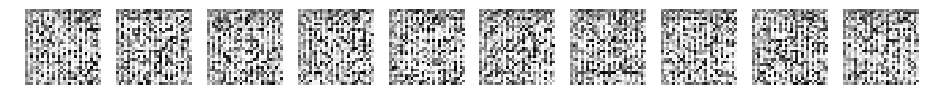

-- Iteration:500
  d_error: 0.06853684037923813
  g_error: 3.241373062133789


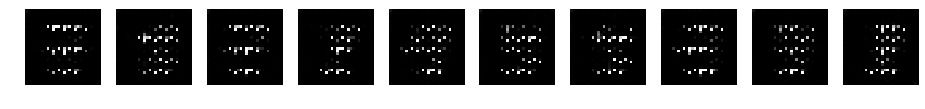

-- Iteration:1000
  d_error: 0.7213794589042664
  g_error: 1.749668002128601


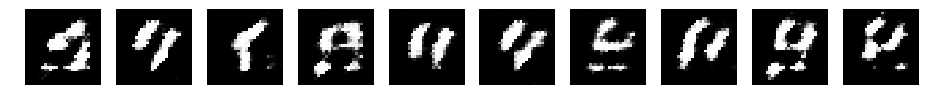

-- Iteration:1500
  d_error: 0.7732537984848022
  g_error: 1.2578258514404297


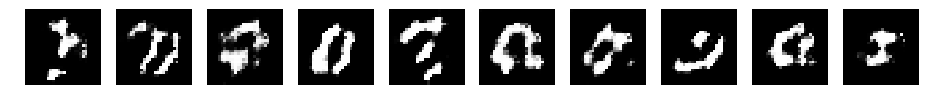

-- Iteration:2000
  d_error: 0.9686241745948792
  g_error: 1.0321711301803589


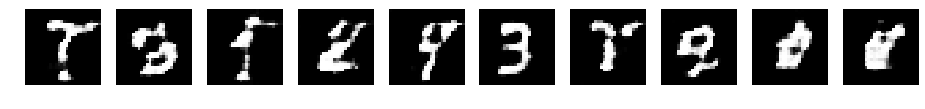

-- Iteration:2500
  d_error: 0.8118053674697876
  g_error: 1.4046106338500977


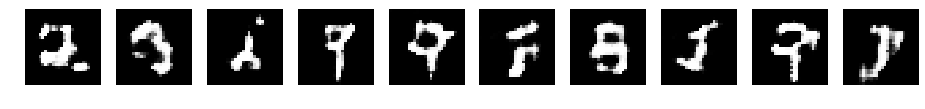

-- Iteration:3000
  d_error: 0.9040271043777466
  g_error: 1.424059271812439


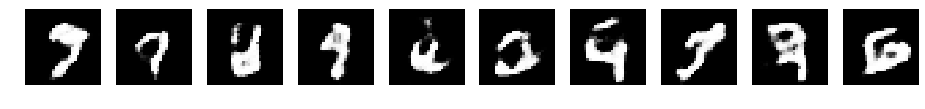

-- Iteration:3500
  d_error: 0.9973600506782532
  g_error: 1.046525478363037


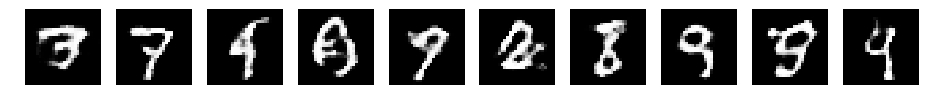

-- Iteration:4000
  d_error: 1.249845027923584
  g_error: 0.8752943277359009


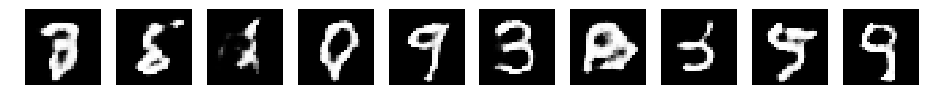

-- Iteration:4500
  d_error: 1.1802382469177246
  g_error: 1.055446743965149


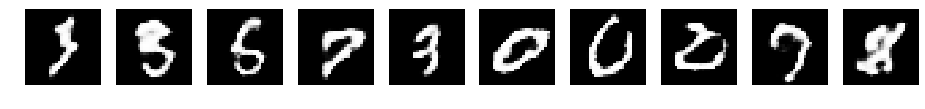

-- Iteration:5000
  d_error: 1.2802103757858276
  g_error: 0.8881727457046509


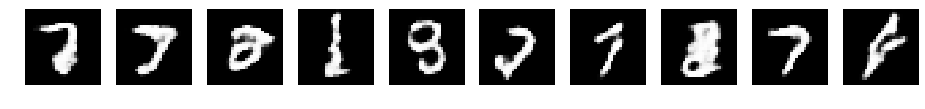

-- Iteration:5500
  d_error: 1.2417974472045898
  g_error: 0.8903175592422485


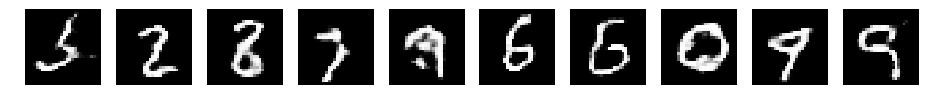

-- Iteration:6000
  d_error: 1.1796233654022217
  g_error: 0.8798403739929199


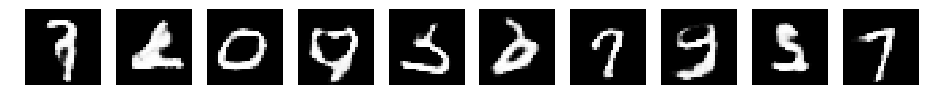

-- Iteration:6500
  d_error: 1.0058352947235107
  g_error: 1.1146659851074219


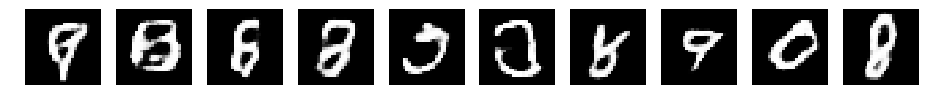

-- Iteration:7000
  d_error: 1.1068413257598877
  g_error: 0.993106484413147


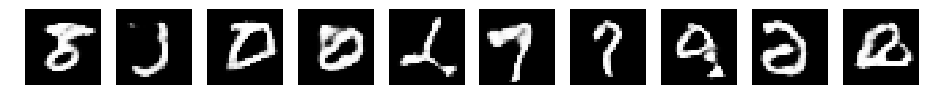

-- Iteration:7500
  d_error: 1.14654541015625
  g_error: 0.9623730778694153


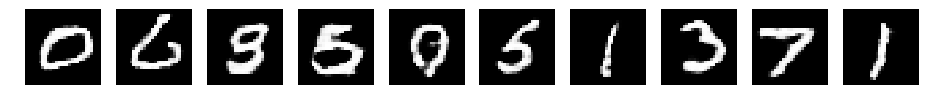

-- Iteration:8000
  d_error: 1.0478180646896362
  g_error: 1.0642672777175903


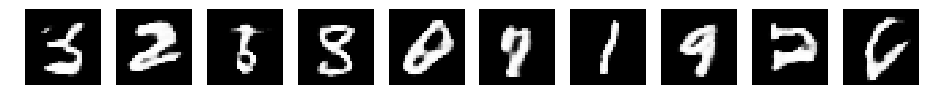

-- Iteration:8500
  d_error: 1.0625948905944824
  g_error: 0.9224421381950378


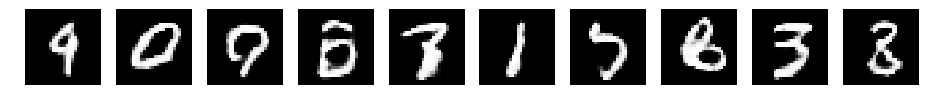

-- Iteration:9000
  d_error: 1.063549518585205
  g_error: 1.0301120281219482


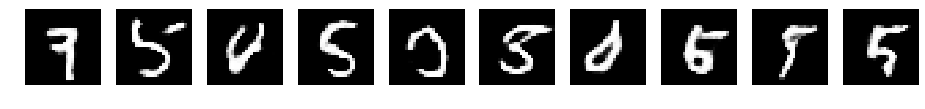

-- Iteration:9500
  d_error: 1.0228240489959717
  g_error: 0.9663342237472534


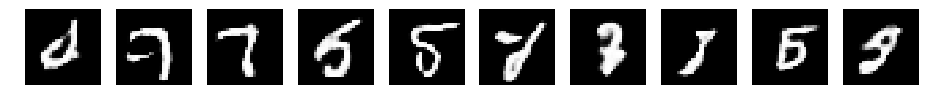

-- Iteration:10000
  d_error: 1.0652055740356445
  g_error: 0.9164840579032898


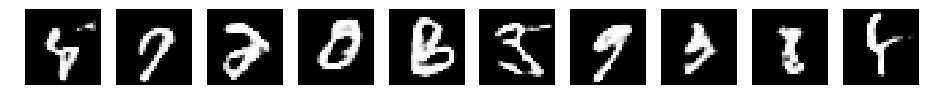

-- Iteration:10500
  d_error: 1.0592641830444336
  g_error: 1.2469104528427124


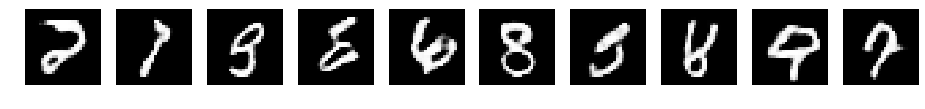

-- Iteration:11000
  d_error: 1.0315929651260376
  g_error: 0.9413997530937195


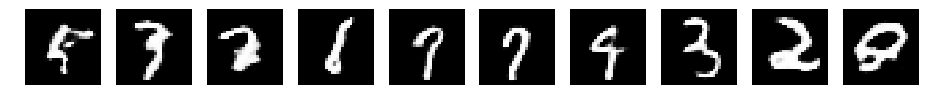

-- Iteration:11500
  d_error: 1.0487984418869019
  g_error: 1.2853337526321411


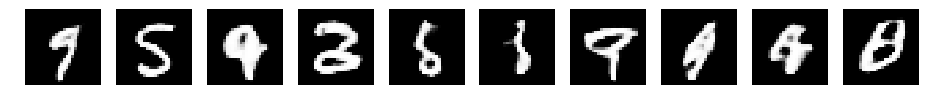

-- Iteration:12000
  d_error: 1.033502459526062
  g_error: 1.112478256225586


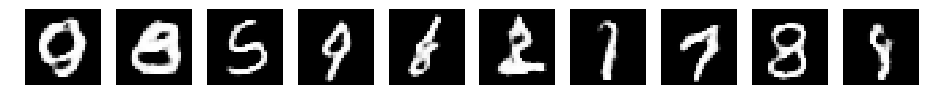

-- Iteration:12500
  d_error: 0.9994763135910034
  g_error: 1.2086002826690674


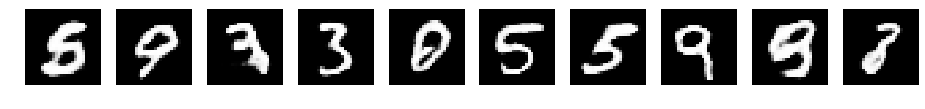

-- Iteration:13000
  d_error: 1.0301768779754639
  g_error: 1.3792434930801392


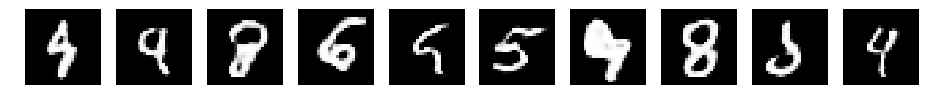

-- Iteration:13500
  d_error: 0.8491605520248413
  g_error: 1.163292646408081


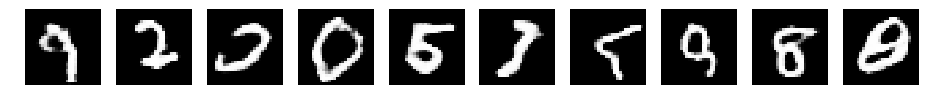

-- Iteration:14000
  d_error: 0.9336144924163818
  g_error: 1.412029504776001


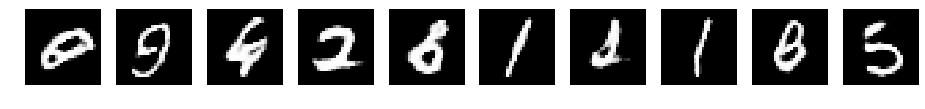

-- Iteration:14500
  d_error: 0.9924326539039612
  g_error: 1.3263380527496338


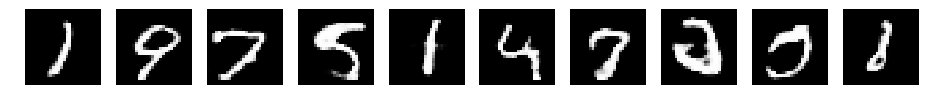

-- Iteration:15000
  d_error: 0.831800639629364
  g_error: 1.2770297527313232


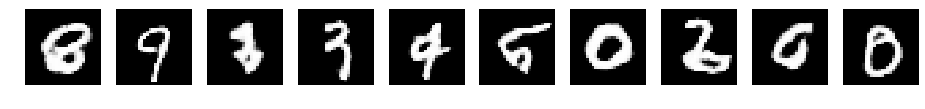

-- Iteration:15500
  d_error: 0.8309652805328369
  g_error: 1.2823683023452759


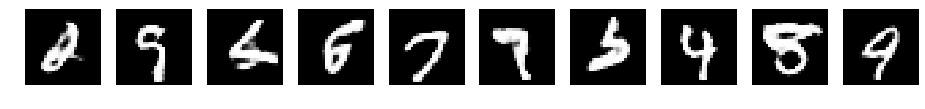

-- Iteration:16000
  d_error: 0.8511674404144287
  g_error: 1.4117259979248047


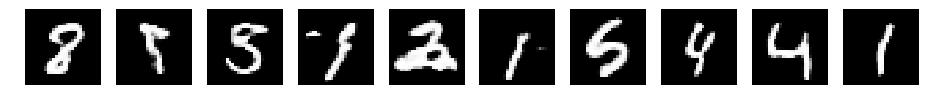

-- Iteration:16500
  d_error: 0.9636028409004211
  g_error: 1.2735368013381958


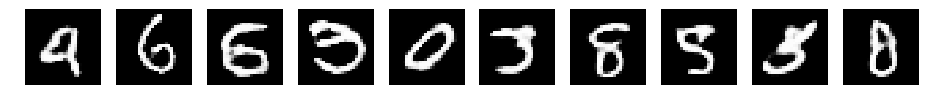

-- Iteration:17000
  d_error: 0.8108938336372375
  g_error: 1.280626893043518


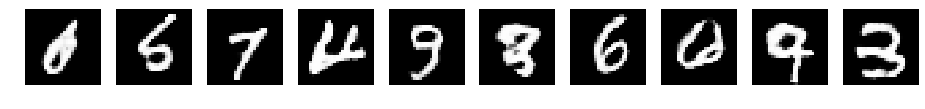

-- Iteration:17500
  d_error: 0.8046252727508545
  g_error: 1.2623474597930908


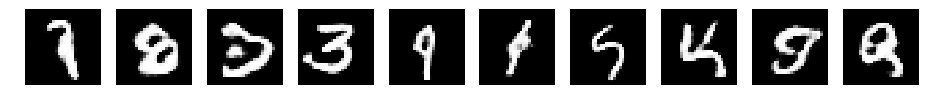

-- Iteration:18000
  d_error: 0.885181725025177
  g_error: 1.2305352687835693


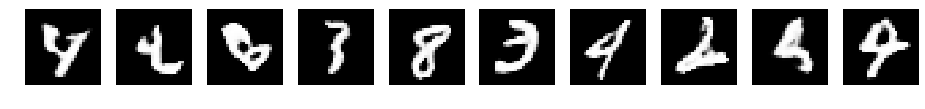

-- Iteration:18500
  d_error: 0.871734619140625
  g_error: 1.5476632118225098


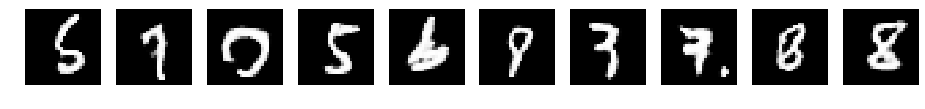

-- Iteration:19000
  d_error: 0.8179527521133423
  g_error: 1.3356728553771973


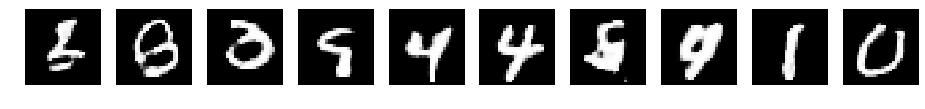

-- Iteration:19500
  d_error: 0.8798304796218872
  g_error: 1.5324139595031738


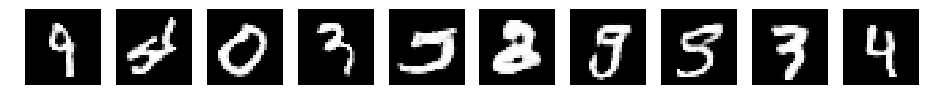

-- Iteration:20000
  d_error: 0.9062066674232483
  g_error: 1.3665865659713745


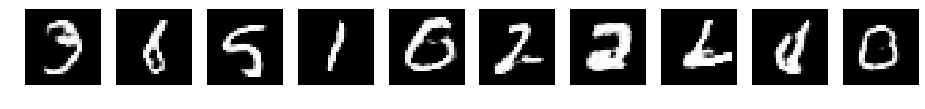

-- Iteration:20500
  d_error: 0.8407924175262451
  g_error: 1.7673637866973877


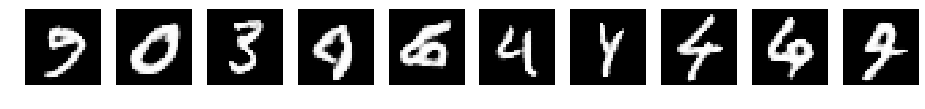

-- Iteration:21000
  d_error: 0.7524442076683044
  g_error: 1.6903414726257324


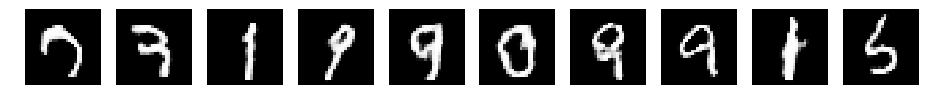

-- Iteration:21500
  d_error: 0.7111967206001282
  g_error: 1.498703956604004


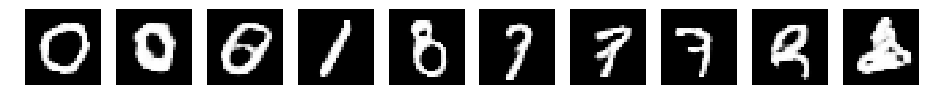

-- Iteration:22000
  d_error: 0.7788736820220947
  g_error: 1.7126613855361938


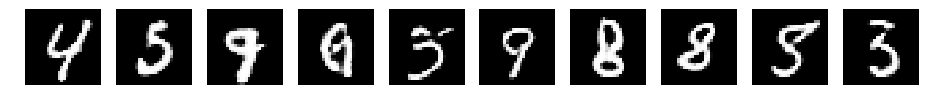

-- Iteration:22500
  d_error: 0.776054859161377
  g_error: 1.4715232849121094


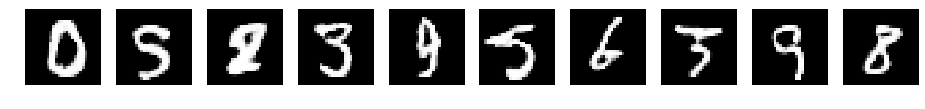

-- Iteration:23000
  d_error: 0.7539663314819336
  g_error: 1.7723720073699951


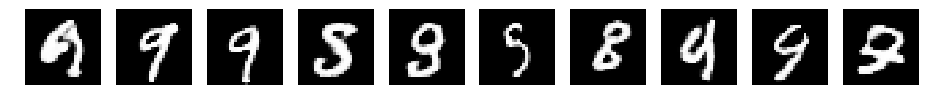

-- Iteration:23500
  d_error: 0.7182935476303101
  g_error: 1.2145024538040161


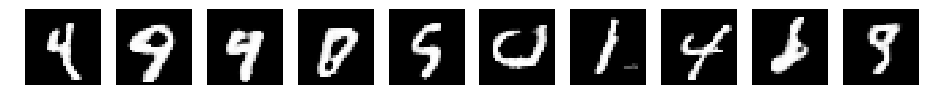

-- Iteration:24000
  d_error: 0.7863702774047852
  g_error: 2.1533327102661133


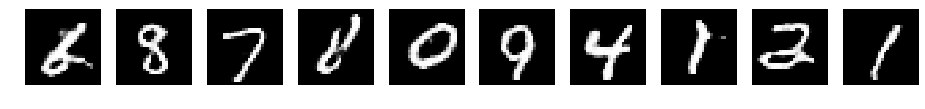

-- Iteration:24500
  d_error: 0.7554070353507996
  g_error: 1.7517699003219604


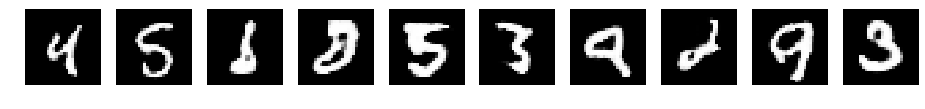

-- Iteration:25000
  d_error: 0.8089586496353149
  g_error: 1.7536848783493042


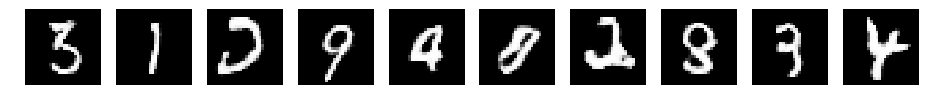

-- Iteration:25500
  d_error: 0.73650723695755
  g_error: 1.8752202987670898


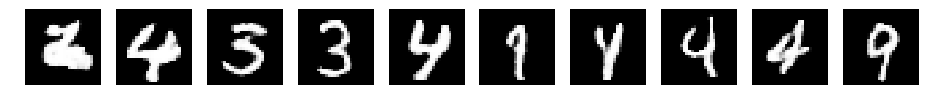

-- Iteration:26000
  d_error: 0.7830286026000977
  g_error: 1.6315301656723022


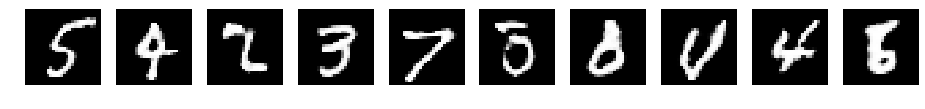

-- Iteration:26500
  d_error: 0.7518619894981384
  g_error: 1.8341128826141357


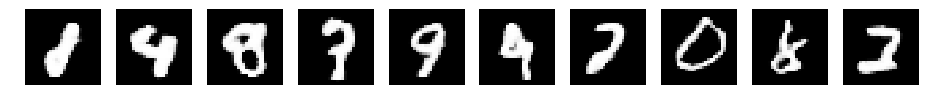

-- Iteration:27000
  d_error: 0.7606616616249084
  g_error: 1.9773550033569336


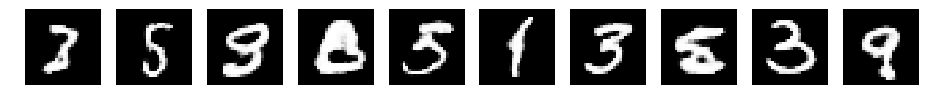

-- Iteration:27500
  d_error: 0.7382222414016724
  g_error: 1.5659064054489136


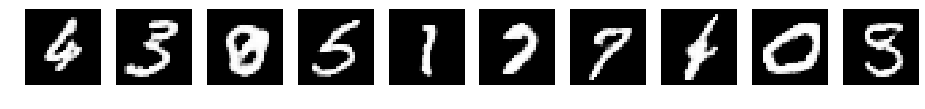

-- Iteration:28000
  d_error: 0.8067439794540405
  g_error: 2.066260576248169


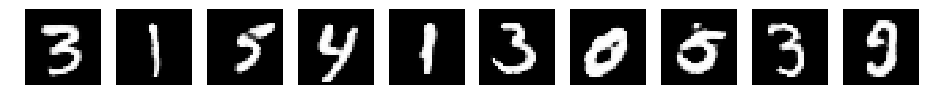

-- Iteration:28500
  d_error: 0.7171334028244019
  g_error: 1.4751222133636475


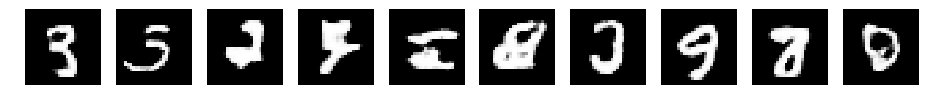

-- Iteration:29000
  d_error: 0.7221136093139648
  g_error: 1.8744601011276245


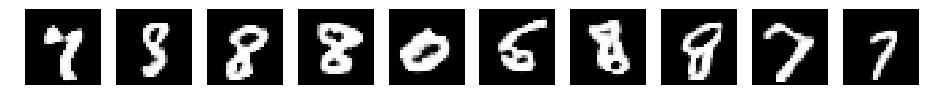

-- Iteration:29500
  d_error: 0.7968043684959412
  g_error: 1.3678333759307861


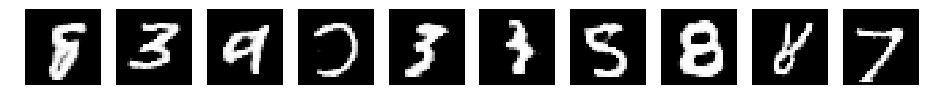

-- Iteration:30000
  d_error: 0.8202551603317261
  g_error: 1.5287353992462158


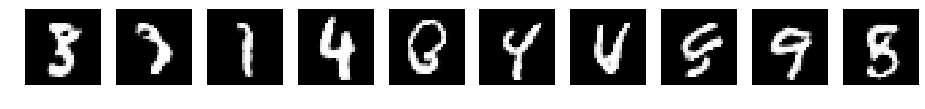

-- Iteration:30500
  d_error: 0.6874514818191528
  g_error: 1.2989530563354492


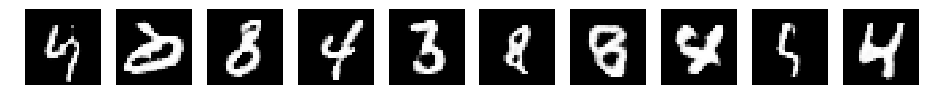

-- Iteration:31000
  d_error: 0.6961493492126465
  g_error: 1.9390809535980225


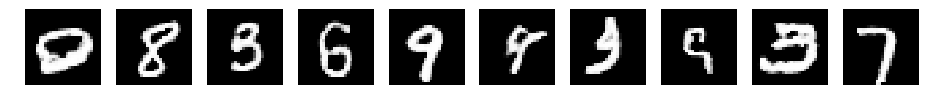

-- Iteration:31500
  d_error: 0.7236523628234863
  g_error: 1.499056339263916


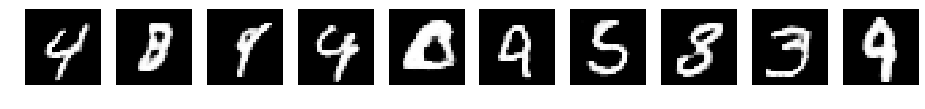

-- Iteration:32000
  d_error: 0.767130970954895
  g_error: 1.500964641571045


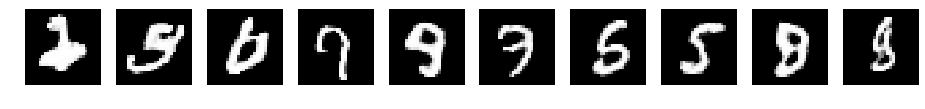

-- Iteration:32500
  d_error: 0.6727954745292664
  g_error: 1.8003838062286377


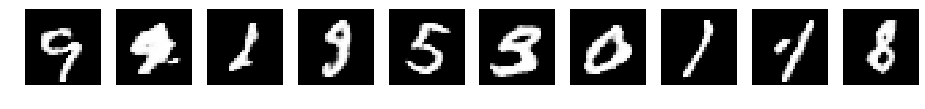

-- Iteration:33000
  d_error: 0.7395201325416565
  g_error: 1.5712196826934814


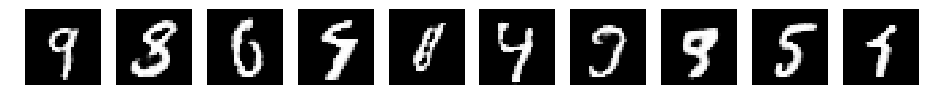

-- Iteration:33500
  d_error: 0.6776860952377319
  g_error: 2.0317044258117676


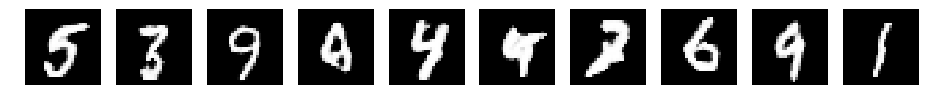

-- Iteration:34000
  d_error: 0.6931538581848145
  g_error: 1.8533415794372559


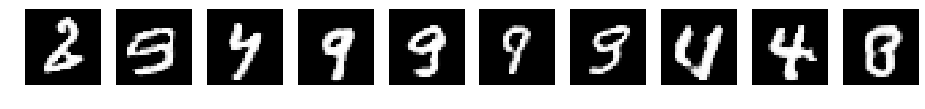

-- Iteration:34500
  d_error: 0.7320181131362915
  g_error: 1.6295907497406006


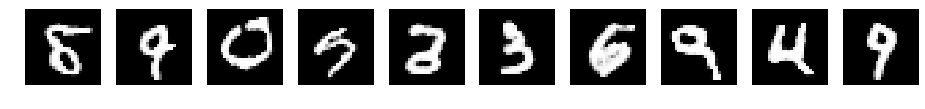

-- Iteration:35000
  d_error: 0.6796697378158569
  g_error: 1.445659875869751


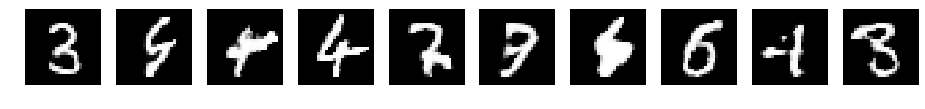

-- Iteration:35500
  d_error: 0.7664241790771484
  g_error: 1.7317683696746826


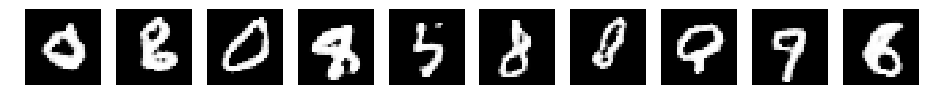

-- Iteration:36000
  d_error: 0.7024692296981812
  g_error: 2.0751726627349854


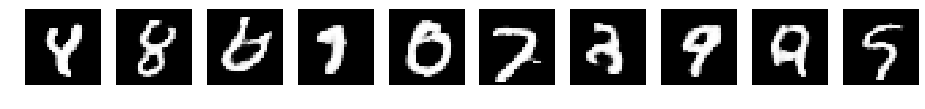

-- Iteration:36500
  d_error: 0.7198744416236877
  g_error: 2.1084017753601074


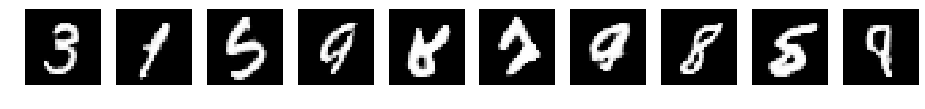

-- Iteration:37000
  d_error: 0.7810643911361694
  g_error: 1.7011823654174805


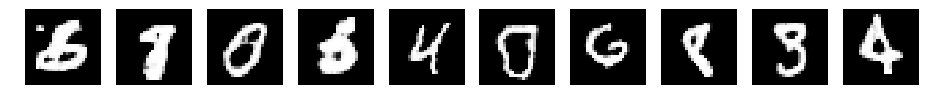

-- Iteration:37500
  d_error: 0.7174509167671204
  g_error: 1.7327083349227905


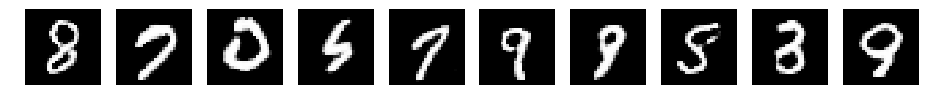

-- Iteration:38000
  d_error: 0.6655368208885193
  g_error: 1.5392340421676636


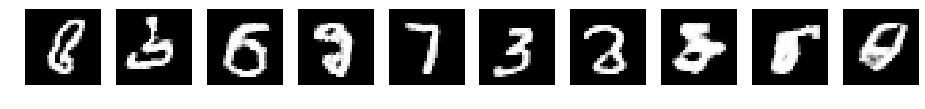

-- Iteration:38500
  d_error: 0.741655707359314
  g_error: 1.6586315631866455


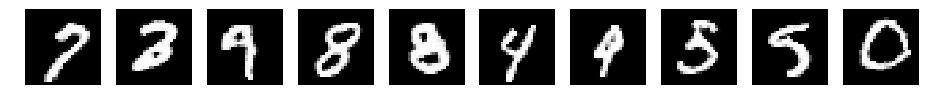

-- Iteration:39000
  d_error: 0.6293578147888184
  g_error: 1.8440271615982056


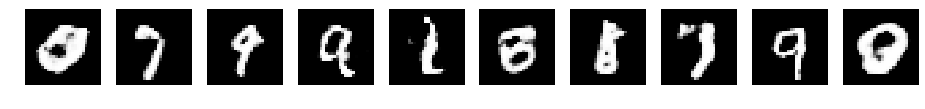

-- Iteration:39500
  d_error: 0.7109780311584473
  g_error: 1.5422157049179077


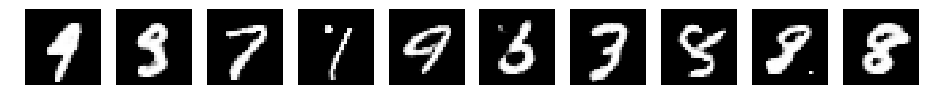

-- Iteration:40000
  d_error: 0.7530300617218018
  g_error: 1.7913858890533447


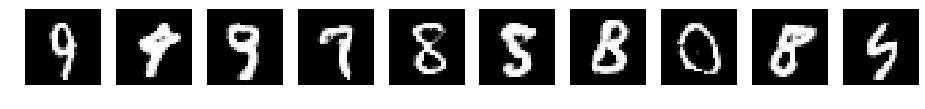

-- Iteration:40500
  d_error: 0.7167437672615051
  g_error: 1.6633145809173584


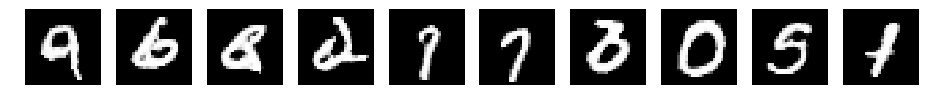

-- Iteration:41000
  d_error: 0.684727668762207
  g_error: 1.8578861951828003


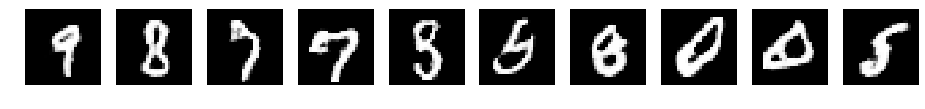

-- Iteration:41500
  d_error: 0.7721717357635498
  g_error: 1.7920095920562744


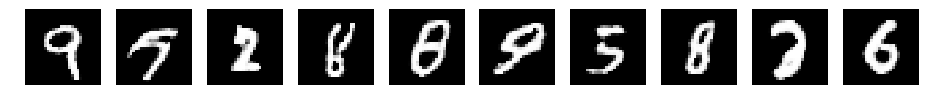

-- Iteration:42000
  d_error: 0.685002326965332
  g_error: 2.2610278129577637


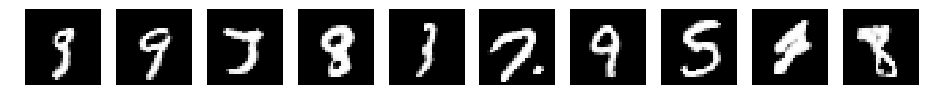

-- Iteration:42500
  d_error: 0.7896028757095337
  g_error: 2.167435646057129


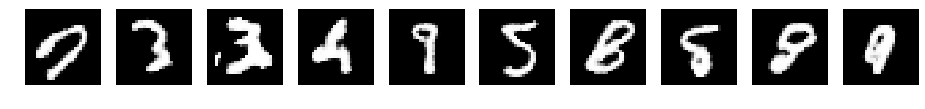

-- Iteration:43000
  d_error: 0.7645118236541748
  g_error: 1.3045912981033325


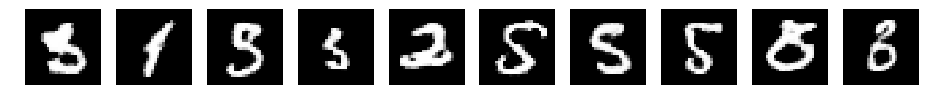

-- Iteration:43500
  d_error: 0.6421093940734863
  g_error: 1.4740122556686401


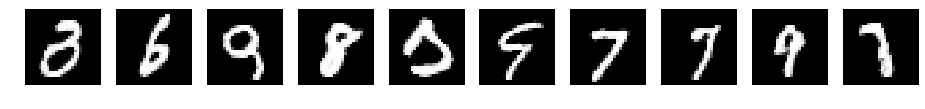

-- Iteration:44000
  d_error: 0.6638866662979126
  g_error: 2.057488203048706


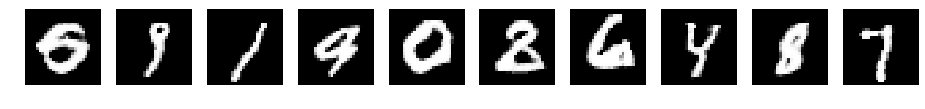

-- Iteration:44500
  d_error: 0.7105540037155151
  g_error: 1.2519614696502686


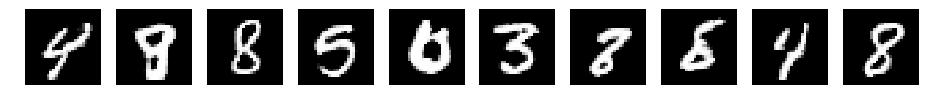

-- Iteration:45000
  d_error: 0.6311085224151611
  g_error: 1.9111632108688354


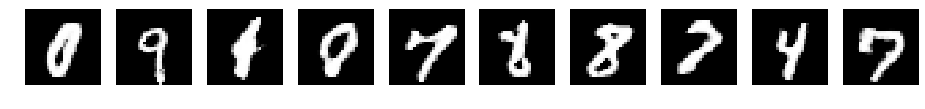

-- Iteration:45500
  d_error: 0.6515045166015625
  g_error: 1.5146032571792603


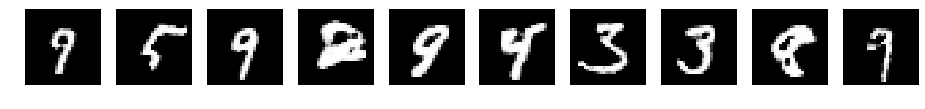

-- Iteration:46000
  d_error: 0.771388053894043
  g_error: 2.3841540813446045


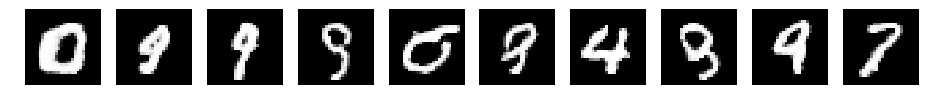

-- Iteration:46500
  d_error: 0.7505793571472168
  g_error: 1.7898740768432617


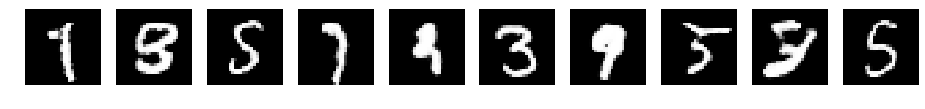

-- Iteration:47000
  d_error: 0.7196980714797974
  g_error: 2.1980550289154053


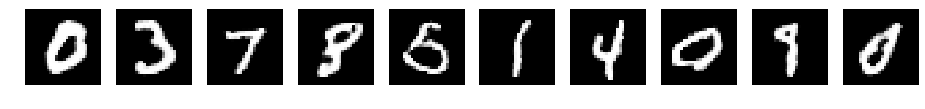

-- Iteration:47500
  d_error: 0.6972446441650391
  g_error: 1.9288030862808228


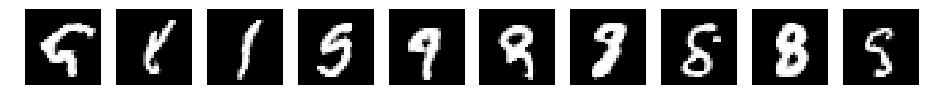

-- Iteration:48000
  d_error: 0.6928034424781799
  g_error: 2.0484495162963867


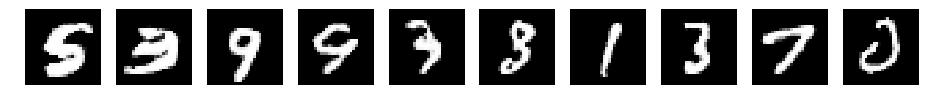

-- Iteration:48500
  d_error: 0.89680016040802
  g_error: 1.9923642873764038


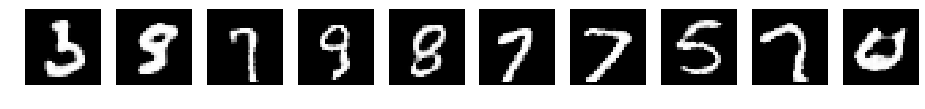

-- Iteration:49000
  d_error: 0.6184966564178467
  g_error: 1.856099009513855


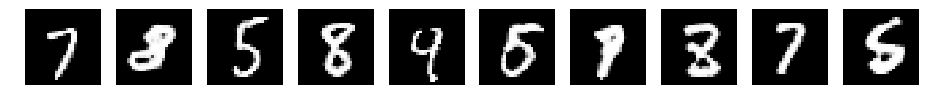

-- Iteration:49500
  d_error: 0.7395766973495483
  g_error: 1.8273108005523682


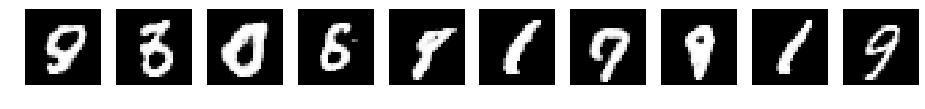

Finished in 1059.1849966049194


In [27]:
start_time = time.time()

TRAIN_ITERATIONS = 50000
train_g = tf.train.AdamOptimizer(learning_rate=8e-4).minimize(g_loss, var_list=g_trainables)
train_d = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(d_loss, var_list=d_trainables)

rounds = []
d_loss_values = []
g_loss_values = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for it in range(TRAIN_ITERATIONS):
        batch_x, _ = mnist.train.next_batch(BATCH_SIZE)  # ignore labels
        batch_x = batch_x.reshape((BATCH_SIZE, IMG_H, IMG_W, IMG_CHANNELS))
        
        batch_z = random_z((BATCH_SIZE, Z_SIZE))
        train_d_res, d_error = sess.run([train_d, d_loss], feed_dict={X: batch_x, Z: batch_z})
        
        batch_z = random_z((BATCH_SIZE, Z_SIZE))
        train_g_res, g_error, d_fake_val, d_fake_logits_val = sess.run([train_g, g_loss, d_fake, d_fake_logits], feed_dict={Z: batch_z})
        
        rounds.append(it)       
        d_loss_values.append(d_error)
        g_loss_values.append(g_error)
        if it % 500 == 0:
            print('-- Iteration:{}'.format(it))
            print("  d_error: {}".format(d_error))
            print("  g_error: {}".format(g_error))
            fake_images = sess.run(g_image, feed_dict={Z: random_z((BATCH_SIZE, Z_SIZE))})
            show_image(fake_images.reshape((BATCH_SIZE, IMG_W, IMG_H)))
    
print("Finished in {}".format(time.time() - start_time))

# G learning rate=8e-4, D learning rate=1e-4, iteration=50,000, K=1

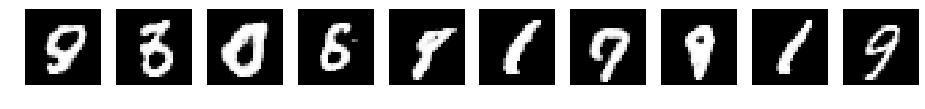

In [29]:
show_image(fake_images.reshape((BATCH_SIZE, IMG_W, IMG_H)))

* Wow!! Surprised result!
* Look at the above training log, G gives quite good fake samples around the iteration 15K(th). After that, the quality of fake images is not improved so much.

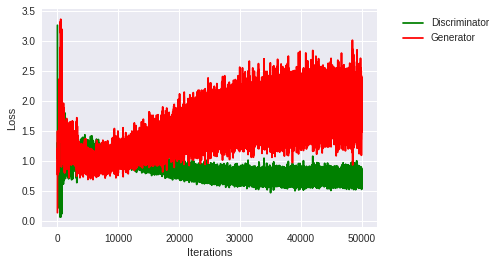

In [30]:
show_loss_chart(rounds, d_loss_values, g_loss_values)